In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import glob
import importlib as imp
% matplotlib inline

In [5]:
from ArcticTools import map
from ArcticTools import EOF

In [6]:
import importlib as imp
imp.reload(EOF)

<module 'ArcticTools.EOF' from '/ocean/xiaoxiny/research/tools/ArcticTools/EOF.py'>

In [7]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc')
e1t= mesh.variables['e1t'][0,400:,:]  # dx
e2t= mesh.variables['e2t'][0,400:,:]  # dy 
e3t= mesh.variables['e3t'][0,:]
tmask= mesh.variables['tmask'][0,:,400:,:]
dep = mesh.variables['gdept_0'][0.,:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [8]:
npzfile = np.load('/ocean/xiaoxiny/research/analysis-cindy/notebooks/phy_field/npz/Isopynal_27.9_EXH001.npz')
emyt = npzfile['x'][:]
emyt.shape

(144, 400, 500)

In [9]:
# Topostrophy-related functions
def gradient(Pressure):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    This function calculate dP_dx, dP_dy
    '''
    dP = d_(Pressure);
    dx = e1t;
    dy = e2t;
    dP_x = dP[0,:]/dx;
    dP_y = dP[1,:]/dy;
    return dP_x, dP_y

def d_(field):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    In order to calculate dP_dx, dP_dy, we need dP. This function does this job.
    '''
    dfield= np.zeros((2,field.shape[0],field.shape[1]))
    # dx
    dfield[0,:, :-1] = field[:, 1:]-field[:, :-1]
    dfield[0,:,-1] = dfield[0,:,-2] # assuming the last two columns have the same dx (and dy)
    # dy
    dfield[1,:-1, :] = field[1:, :]-field[:-1, :]
    dfield[1,-1,:] = dfield[1,-2,:]
    return dfield

def calulateT(year,month,ENG,layer):
    '''Calculate T = (u X (Delta H) in z direction)
    Input:
    year: calender year
    ENG: 'EXH001', EXH005','ENG3'
    layer: NEMO layer
    
    Output:
    result of T
    '''
    # load vel
    u= load_v('U',year,month, tmask= tmask, ENG=ENG)
    v= load_v('V',year,month, tmask= tmask, ENG=ENG)

    # arrange array in order
    totU= np.array((u[layer,:,:],v[layer,:,:]))
    totdH = np.array((dbathy[0],dbathy[1]))

    # allocation
    T = np.zeros_like(u[layer,:,:])
    #U = u[layer,:,:].mean()**2 + v[layer,:,:].mean()**2
    #dH= totdH[0,:,:].mean()**2 + totdH[1,:,:].mean()**2
    # calculate cross product
    for i in range (totdH.shape[1]):
        for j in range (totdH.shape[2]):          
            T[i,j] = np.float(-totU[1,i,j]*totdH[0,i,j] + totU[0,i,j]*totdH[1,i,j])#/(U*dH)**0.5#* e1t[i,j] * e2t[i,j]
    # masked 9 and in valid numbers
    test = np.ma.masked_invalid(np.ma.masked_where(T==0,T))
    return test

def load_v(vel_comp,year,month,tmask, ENG):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}
    #print (glob.glob('/ocean/xiaoxiny/research/result_jasper/data_monthly/*%s*%s*%s*month%0.2d*.nc'%(ENG,vel_comp,year,month))[0])
    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_monthly/*%s*%s*%s*month%0.2d*.nc'%(ENG,vel_comp,year,month))[0])\
as temp:
        data  = temp.variables[vels[vel_comp]][0,:,400:,:]
        data [tmask == 0] = np.nan
    return data

In [10]:
dbathy= gradient(bathy)
def load_T(year,month,dbathy=dbathy):

    T = np.zeros((50,400,544))
    for depnum in range (50):
        T[depnum,:,:] = calulateT(year,month,ENG='EXH001',layer=depnum)
    return T

In [11]:
def load_isopycnal_data(emyt):
    '''Input: isopycnal layers
    Output: extract salinity data from isopynal layer'''
    data = np.zeros_like(emyt)
    timenum = 0 
    
    
    for i in range (data.shape[0]): # time
        year = int(timenum/12)+2002
        month= timenum%12+1
        print ('year: %s, month: %s'%(year,month))
        tempdata = load_T(year,month)
        for j in range (data.shape[1]):
            for k in range (data.shape[2]): # lat,lon
                templayer= emyt[i,j,k]
                if ~np.isnan(templayer):
                    data[timenum,j,k] =  tempdata[templayer,j,k]
        timenum +=1
    return data

In [12]:
#npzfile = np.load(EXH005_isopynal_layers)
npzfile = np.load('/ocean/xiaoxiny/research/analysis-cindy/notebooks/phy_field/npz/AlongIsopynal_T_EXH001.npz')

In [13]:
T_iso = np.ma.masked_invalid(npzfile['x'][:])

In [14]:
T_iso.shape

(144, 400, 500)

In [15]:
smean = EOF.seasonal_mean(T_iso[:,:,:])

In [16]:
smean.shape

(12, 400, 500)

#### Monthly mean I substracted before conducting EOF.

For example, Month: 1 is the mean for all January data from 2002 to 2013.

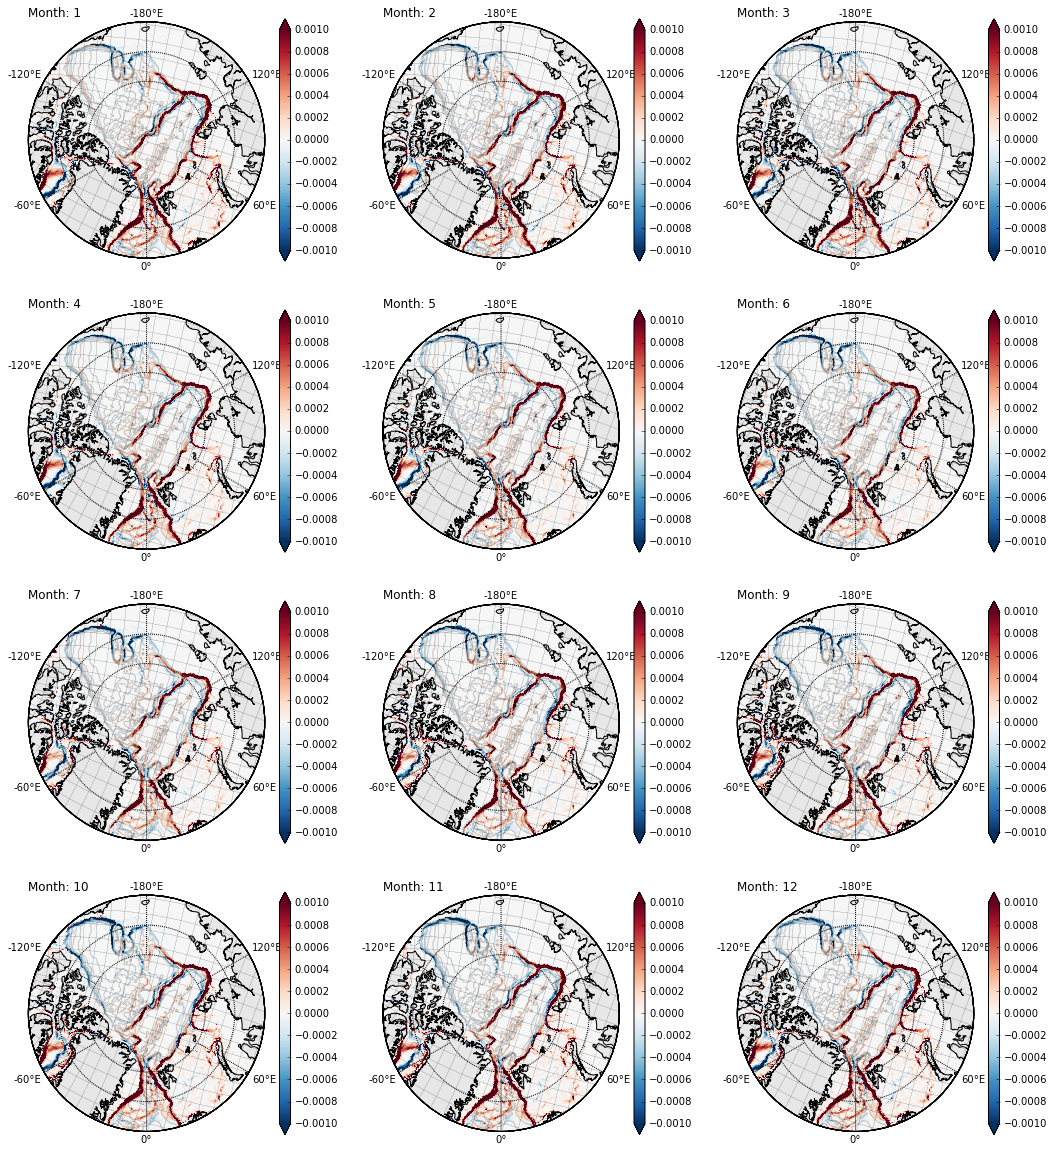

In [17]:
fig,axes = plt.subplots(4,3,figsize =(18,20))

for i,ax in zip (range (12), axes.flat):
    m,x_lon, y_lat = map.mapping(70,ax = ax)
    x_lon = x_lon[:,:500]
    y_lat = y_lat[:,:500]
    CS = m.pcolor(x_lon, y_lat, smean[i, :, :], cmap='RdBu_r',vmin=-0.001,vmax=0.001)
    plt.colorbar(CS, extend='both',ax = ax)
    ax.set_title('Month: %s'%(i+1),loc='left')

# EOF

In [18]:
deseanonal = EOF.seasonal_decomp3d(T_iso[:,:,:500])
deseanonal.shape

(400, 500, 144)

In [21]:
EOFs, PC, expvar = EOF.EOF(deseanonal)

/ocean/xiaoxiny/research/tools/ArcticTools/EOF.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  eof[i, :] = np.squeeze(E[:, i]).T
/ocean/xiaoxiny/research/tools/ArcticTools/EOF.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  PC[i, :]  = np.squeeze(Z[i, :])


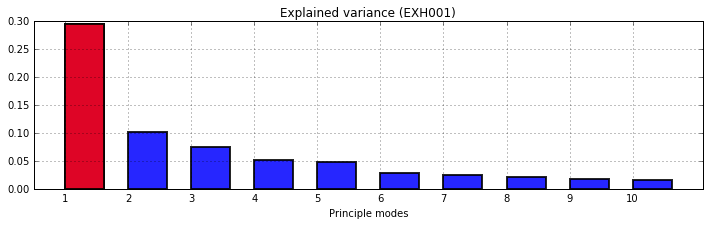

In [22]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color = 'r',label='The loading mode of AO')
ax.set_xticks(np.arange(1, 11))
#LG = ax.legend(numpoints=1, bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
#[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance (EXH001)', fontsize=12)

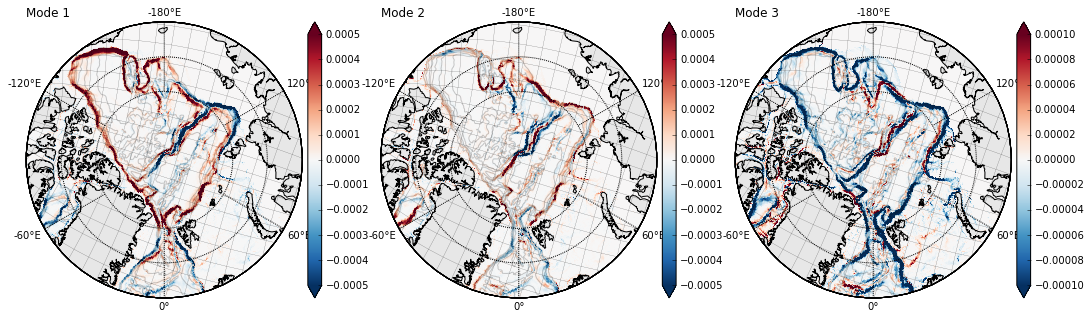

In [27]:
fig = plt.figure(figsize = (18,5))
plt.subplot(131)
m,x_lon, y_lat = map.mapping(70)
x_lon = x_lon[:,:500]
y_lat = y_lat[:,:500]

CS = m.pcolor(x_lon, y_lat, -EOFs[:, :, 0], cmap='RdBu_r',vmin=-0.0005,vmax=0.0005)
m.colorbar(extend='both')
plt.title('Mode 1',loc='left')

plt.subplot(132)
m,x_lon, y_lat = map.mapping(70)
x_lon = x_lon[:,:500]
y_lat = y_lat[:,:500]
CS = m.pcolor(x_lon, y_lat, -EOFs[:, :, 1], cmap='RdBu_r',vmin=-0.0005,vmax=0.0005)
m.colorbar(extend='both')
plt.title('Mode 2',loc='left')

plt.subplot(133)
m,x_lon, y_lat = map.mapping(70)
x_lon = x_lon[:,:500]
y_lat = y_lat[:,:500]
CS = m.pcolor(x_lon, y_lat, EOFs[:, :, 2], cmap='RdBu_r',vmin=-0.0005,vmax=0.0005)
m.colorbar(extend='both')
plt.title('Mode 3',loc='left')

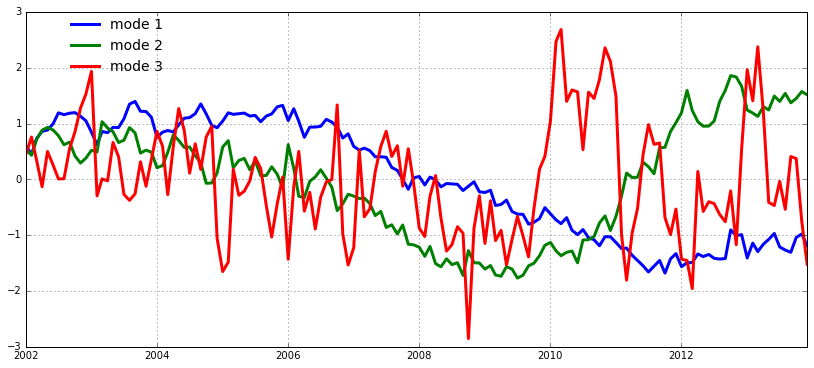

In [29]:
import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

fig = plt.figure(figsize=(14, 6))

ax = fig.gca(); ax.grid()
ax.plot(date_list, -PC[0, :], '-',  lw=3, label='mode 1')
ax.plot(date_list, -PC[1, :], '-', lw=3, label='mode 2')
ax.plot(date_list, PC[2, :], '-',  lw=3, label='mode 3')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)